In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv('cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009329 entries, 0 to 1009328
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   asin                  1009329 non-null  object 
 1   time                  1009329 non-null  object 
 2   id                    1009329 non-null  float64
 3   price                 1009329 non-null  float64
 4   currency              1009329 non-null  object 
 5   crawlTime             1009329 non-null  object 
 6   condition             1009329 non-null  object 
 7   sellerName            1009329 non-null  object 
 8   sellerId              1009329 non-null  object 
 9   sellerbewertung       754862 non-null   float64
 10  seller_sterne         1009329 non-null  float64
 11  lieferdatum           973966 non-null   object 
 12  lieferpreis           973966 non-null   float64
 13  lieferung_durch       1009329 non-null  object 
 14  ranking               1009329 non-

In [12]:
## Calculate for each Asin/Seller Pair the number of price_changes, avg_price_change and avg_price_change_percent

In [13]:
unique_asin_seller = df[['asin', 'sellerName']].drop_duplicates()
len(unique_asin_seller)

11921

In [14]:
import pandas as pd
from datetime import timedelta

# Assuming your DataFrame is called df
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")

# First, sort the DataFrame by 'asin', 'sellerName', 'condition', 'time', and 'price'
df = df.sort_values(by=['asin', 'sellerName','condition', 'time','price'])

# Reset the index after sorting
df.reset_index(drop=True, inplace=True)

# Compute the price changes
df['price_change'] = (
    (df['price'] != df['price'].shift(1)) &
    (df['condition'] == df['condition'].shift(1)) &
    (df['sellerName'] == df['sellerName'].shift(1)) &
    (df['asin'] == df['asin'].shift(1)) &
    ((df['time'] - df['time'].shift(1)) == timedelta(hours=1))
)

# Calculate absolute price change and percentage price change for each row where a price change occurred
df['abs_price_change'] = df['price'].diff().where(df['price_change']).fillna(0).abs()
df['percent_price_change'] = ((df['price'].pct_change() * 100).where(df['price_change']).fillna(0)).round(2).abs()

# Calculate the observation time for each seller-asin combination
observation_time = df.groupby(['asin', 'sellerName'])['time'].agg(['min', 'max']).reset_index()
observation_time['observation_time'] = observation_time['max'] - observation_time['min']

# Create a DataFrame containing all unique asin/sellerName pairs
unique_asin_seller = df[['asin', 'sellerName']].drop_duplicates()

# Now, group by 'asin' and 'sellerName' and sum the 'price_change' column to get the number of price changes
price_changes = df.groupby(['asin', 'sellerName'])['price_change'].sum().reset_index()

# Merge the unique_asin_seller DataFrame with price_changes, using an outer join
price_changes = pd.merge(unique_asin_seller, price_changes, on=['asin', 'sellerName'], how='left')

# Fill missing values with zeros in the price_changes column
price_changes['price_change'] = price_changes['price_change'].fillna(0)

# Group by 'asin' and 'sellerName' and calculate the average absolute price change and average percentage price change without considering 0 values
avg_price_changes = df[df['price_change']].groupby(['asin', 'sellerName'])[['abs_price_change', 'percent_price_change']].mean().reset_index()

# Merge the price_changes, avg_price_changes, and observation_time DataFrames using outer joins
result_df = pd.merge(price_changes, avg_price_changes, on=['asin', 'sellerName'], how='left')
result_df = pd.merge(result_df, observation_time[['asin', 'sellerName', 'observation_time']], on=['asin', 'sellerName'], how='left')

# Fill NaN values in the avg_abs_price_change and avg_percent_price_change columns with zeros
result_df['abs_price_change'] = result_df['abs_price_change'].fillna(0)
result_df['percent_price_change'] = result_df['percent_price_change'].fillna(0)

# Rename the 'price_change' column to 'num_price_changes'
result_df = result_df.rename(columns={'price_change': 'num_price_changes'})

# Print the result DataFrame
result_df



,asin,sellerName,num_price_changes,abs_price_change,percent_price_change,observation_time
0,B00000JD6K,Kidia,17,0.800000,0.840000,6 days 08:00:00
1,B00000JD6K,STILE IMMAGINE DIGITAL HD,0,0.000000,0.000000,6 days 08:00:00
2,B00005KIRS,Amazon Warehouse,4,0.280000,0.850000,0 days 20:00:00
3,B00005KIRS,Arlambo,55,0.654000,1.484727,6 days 08:00:00
4,B00005KIRS,Bambini Factory Deals,15,0.270000,0.830000,1 days 16:00:00
...,...,...,...,...,...,...
11916,B0BNC8RXH1,Taschengelddieb,28,0.345357,0.787143,6 days 08:00:00
11917,B0BNC8RXH1,amazon,12,0.347500,0.779167,6 days 08:00:00
11918,B0BNC8RXH1,e-joker,13,4.151538,8.257692,5 days 05:00:00
11919,B0BNC8RXH1,ms-plueth,0,0.000000,0.000000,6 days 08:00:00


In [15]:
len(result_df)

11921

In [16]:
df_filtered = df[(df['asin'] == 'B0BNC8RXH1') & (df['sellerName'] == 'Taschengelddieb')]
df_filtered

,asin,time,id,price,currency,crawlTime,condition,sellerName,sellerId,sellerbewertung,...,buyBoxWinner,numberOfSellers,trigByReactive,time_gap,copyed_cause_missing,Fulfillment_type,date_diff,price_change,abs_price_change,percent_price_change
1008859,B0BNC8RXH1,2023-03-19 13:00:00,2501.0,43.36,€,2023-03-19 13:31:28.127709,Neu,Taschengelddieb,A2ABL365H1I2MT,284.16,...,False,6.0,False,0.0,False,FBM,6.0,False,0.00,0.00
1008860,B0BNC8RXH1,2023-03-19 14:00:00,11706.0,43.37,€,2023-03-19 14:36:46.849359,Neu,Taschengelddieb,A2ABL365H1I2MT,284.16,...,False,6.0,False,0.0,False,FBM,6.0,True,0.01,0.02
1008861,B0BNC8RXH1,2023-03-19 15:00:00,20941.0,44.04,€,2023-03-19 15:43:49.552154,Neu,Taschengelddieb,A2ABL365H1I2MT,284.16,...,False,6.0,False,0.0,False,FBM,6.0,True,0.67,1.54
1008862,B0BNC8RXH1,2023-03-19 16:00:00,30166.0,44.54,€,2023-03-19 16:52:53.249373,Neu,Taschengelddieb,A2ABL365H1I2MT,284.16,...,False,6.0,False,0.0,False,FBM,6.0,True,0.50,1.14
1008863,B0BNC8RXH1,2023-03-19 19:00:00,48596.0,43.36,€,2023-03-19 19:03:35.472483,Neu,Taschengelddieb,A2ABL365H1I2MT,284.16,...,False,6.0,False,0.0,False,FBM,6.0,False,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008960,B0BNC8RXH1,2023-03-25 19:00:00,979539.0,43.36,€,2023-03-25 19:16:59.494619,Neu,Taschengelddieb,A2ABL365H1I2MT,287.04,...,False,8.0,False,0.0,False,FBM,23.0,False,0.00,0.00
1008961,B0BNC8RXH1,2023-03-25 20:00:00,989102.0,43.36,€,2023-03-25 20:22:51.532350,Neu,Taschengelddieb,A2ABL365H1I2MT,287.04,...,False,8.0,False,0.0,False,FBM,23.0,False,0.00,0.00
1008962,B0BNC8RXH1,2023-03-25 21:00:00,998701.0,44.14,€,2023-03-25 21:28:02.524711,Neu,Taschengelddieb,A2ABL365H1I2MT,287.04,...,False,8.0,False,0.0,False,FBM,23.0,True,0.78,1.80
1008963,B0BNC8RXH1,2023-03-19 17:00:00,39398.0,43.36,€,2023-03-19 17:58:12.229350,New,Taschengelddieb,A2ABL365H1I2MT,284.16,...,False,6.0,False,0.0,False,FBM,NaN,False,0.00,0.00


# Calculate the mean and median of avg_abs_price_change for the whole result_df

In [17]:
len(result_df)

11921

In [18]:
df_algorithmic_seller_names = pd.read_csv('df_algorithmic_seller_names.csv')

# Create a second dataframe holding the asin/seller pairs for amazon and Amazon Warehouse
# Create a list of seller names you want to filter
seller_names = ['amazon', 'Amazon US', 'Amazon UK']
seller_names_warehouse = ['Amazon Warehouse ']
seller_names_algorithmic_list = df_algorithmic_seller_names['AlgorithmicSellerNames'].tolist()
seller_names_algorithmic_list.remove('amazon')
seller_names_algorithmic_list.remove('Amazon Warehouse ')

distinct_values = df['sellerName'].unique()
seller_names_non_algorithmic = set(distinct_values) - set(seller_names_algorithmic_list)


amazon_df = result_df[result_df['sellerName'].isin(seller_names)]
warehouse_df = result_df[result_df['sellerName'].isin(seller_names_warehouse)]
algo_seller_df = result_df[result_df['sellerName'].isin(seller_names_algorithmic_list)]
non_algo_seller_df = result_df[result_df['sellerName'].isin(seller_names_non_algorithmic)]

In [19]:
print(len(seller_names_non_algorithmic))

1806


In [24]:
# Calculate the average and median of the 'avg_abs_price_change' column (excluding zeros) for each DataFrame
avg_amazon = amazon_df[amazon_df['abs_price_change'] != 0]['abs_price_change'].mean()
median_amazon = amazon_df[amazon_df['abs_price_change'] != 0]['abs_price_change'].median()

avg_warehouse = warehouse_df[warehouse_df['abs_price_change'] != 0]['abs_price_change'].mean()
median_warehouse = warehouse_df[warehouse_df['abs_price_change'] != 0]['abs_price_change'].median()

avg_algorithmic = algo_seller_df[algo_seller_df['abs_price_change'] != 0]['abs_price_change'].mean()
median_algorithmic = algo_seller_df[algo_seller_df['abs_price_change'] != 0]['abs_price_change'].median()

avg_non_algo = non_algo_seller_df[non_algo_seller_df['abs_price_change'] != 0]['abs_price_change'].mean()
meidan_non_algo = non_algo_seller_df[non_algo_seller_df['abs_price_change'] != 0]['abs_price_change'].median()



#Print Lengths
print("Lengths:")
print("Amazon",len(amazon_df))
print("Warehouse",len(warehouse_df))
print("Algorithmic",len(algo_seller_df))
print("Non-Algorithmic",len(non_algo_seller_df))

# Drop all rows where the absolute price change is 0 for the Amazon dataframe
amazon_df = amazon_df[amazon_df['abs_price_change'] != 0]

# Drop all rows where the absolute price change is 0 for the Warehouse dataframe
warehouse_df = warehouse_df[warehouse_df['abs_price_change'] != 0]

# Drop all rows where the absolute price change is 0 for the Algorithmic Sellers dataframe
algo_seller_df = algo_seller_df[algo_seller_df['abs_price_change'] != 0]

# Drop all rows where the absolute price change is 0 for the Non-Algorithmic Sellers dataframe
non_algo_seller_df = non_algo_seller_df[non_algo_seller_df['abs_price_change'] != 0]


# Print the results
print("Amazon: avg =", avg_amazon, "median =", median_amazon)
print("Warehouse: avg =", avg_warehouse, "median =", median_warehouse)
print("Algorithmic: avg =", avg_algorithmic, "median =", median_algorithmic)
print("Non Algorithmic: avg =", avg_non_algo, "median =", meidan_non_algo)


Lengths:
Amazon 624
Warehouse 367
Algorithmic 3089
Non-Algorithmic 2590
Amazon: avg = 1.5035005982606562 median = 0.961500000000002
Warehouse: avg = 1.2371522050975752 median = 0.7876923076923035
Algorithmic: avg = 3.88757438455211 median = 1.3330000000000048
Non Algorithmic: avg = 3.6906067257364983 median = 1.054206349206343


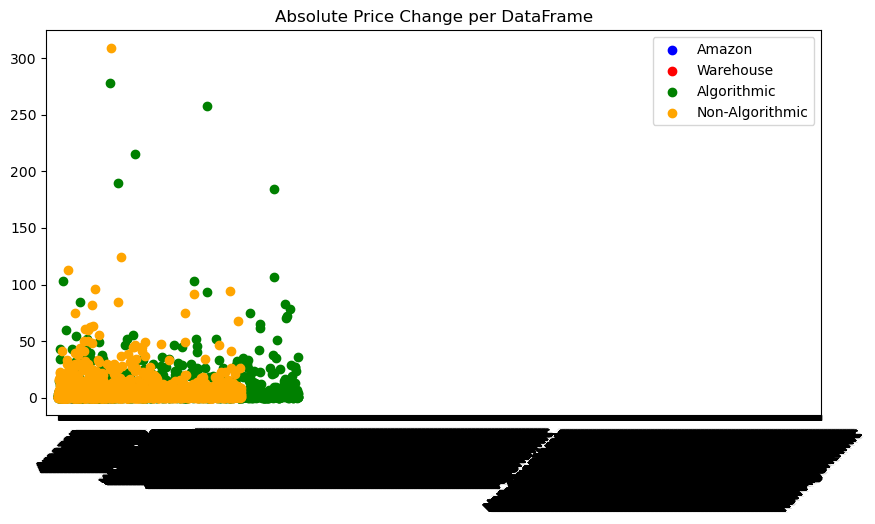

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Get the non-zero absolute price change values from each DataFrame
amazon_values = amazon_df[amazon_df['abs_price_change'] != 0]['abs_price_change'].tolist()
warehouse_values = warehouse_df[warehouse_df['abs_price_change'] != 0]['abs_price_change'].tolist()
algorithmic_values = algo_seller_df[algo_seller_df['abs_price_change'] != 0]['abs_price_change'].tolist()
remaining_values = non_algo_seller_df[non_algo_seller_df['abs_price_change'] != 0]['abs_price_change'].tolist()

# Create a list of all the non-zero values and their corresponding indices
values = amazon_values + warehouse_values + algorithmic_values + remaining_values
indices = np.concatenate([np.arange(len(amazon_values)), np.arange(len(warehouse_values)), np.arange(len(algorithmic_values)), np.arange(len(remaining_values))])

# Define the colors for each DataFrame and create a dictionary of labels for the colors
colors = ['blue', 'red', 'green', 'orange']
color_labels = {'blue': 'Amazon', 'red': 'Warehouse', 'green': 'Algorithmic', 'orange': 'Non-Algorithmic'}

# Create a plot with four columns of points, with each DataFrame represented in a different color
plt.figure(figsize=(10, 5))
for df, color in zip([amazon_values, warehouse_values, algorithmic_values, remaining_values], colors):
    plt.scatter(indices[:len(df)], df, color=color, label=color_labels[color])

# Set the xticks and xticklabels
xticks = np.concatenate([np.arange(len(amazon_values)), np.arange(len(warehouse_values)) + len(amazon_values), np.arange(len(algorithmic_values)) + len(amazon_values + warehouse_values), np.arange(len(remaining_values)) + len(amazon_values + warehouse_values + algorithmic_values)])
xticklabels = ['Amazon'] * len(amazon_values) + ['Warehouse'] * len(warehouse_values) + ['Algorithmic'] * len(algorithmic_values) + ['Non-Algorithmic'] * len(remaining_values)
plt.xticks(ticks=xticks, labels=xticklabels, rotation=45)

# Add title and legend
plt.title('Absolute Price Change per DataFrame')
plt.legend()

# Show the plot
plt.show()
